In [32]:
import sys
sys.path.append("../")

In [33]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
import os
#import pandas as pd
import numpy as np
import cv2
#from PIL import Image
import random
#import tensorflow as tf
#import re
import datetime
import io
#from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import pickle
#import string
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Conv2D, MaxPooling2D, Reshape, Dropout, BatchNormalization, Activation
from utils import score_prediction
import yaml 
import json
from preprocessing.preproc_functions import read_image, normalize_0_mean_1_variance, normalize_0_1, read_annotation, convert_annotation_one_hot
from predictors.predictor import PredictorFCN
from data_generators.data_generator import DataGenerator
from utils.score_prediction import score_prediction 
from keras.applications.vgg16 import preprocess_input

%matplotlib inline

In [35]:
with open('../configs/config.yml') as f:
    config = yaml.load(f)
config['labels_file'] = '../' + config['labels_file']
config['dataset_folder'] = '../' + config['dataset_folder']

config['network']['graph_path'] = '../' + config['network']['graph_path']
config['predict']['weights_file'] = '../' + config['predict']['weights_file']

y_size = config['image']['image_size']['y_size']
x_size = config['image']['image_size']['x_size']
num_classes = config['network']['num_classes']

/home/giovanni/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [36]:
with open(config['labels_file']) as f:
    dataset = json.load(f)

In [150]:
dataset_test = dataset['test']

In [151]:
len(dataset_test)

223

In [152]:
predictor = PredictorFCN(config)

In [157]:
index = random.randint(0, len(dataset_test) - 1)
filename = dataset_test[index]['filename']
annotation_name = dataset_test[index]['annotation']

In [158]:
image_orig = read_image(config['dataset_folder'], filename, y_size, x_size, black_white = False)
#image = normalize_0_mean_1_variance(image_orig)
image = preprocess_input(image_orig, mode='tf') 

annotation = read_annotation(config['dataset_folder'], annotation_name, y_size, x_size)
annotation_one_hot = convert_annotation_one_hot(annotation, y_size, x_size, num_classes = config['network']['num_classes'])
annotation = np.argmax(annotation_one_hot, axis=2)

In [159]:
prediction = predictor.predict(np.expand_dims(image, axis=0))[0]
pred_classes = np.argmax(prediction, axis=2)

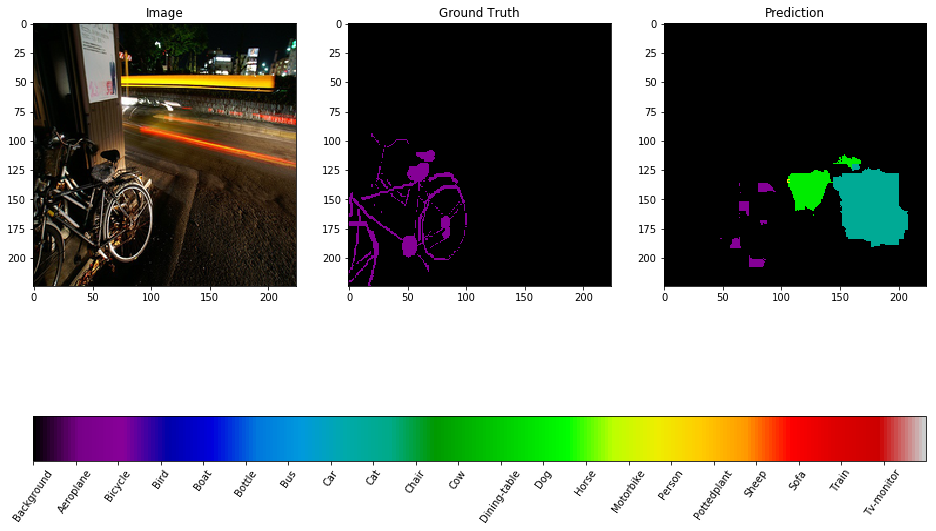

In [160]:
fig, axs = plt.subplots(1, 3, figsize=(16, 16))

images = []

axs[0].set_title("Image")
axs[1].set_title("Ground Truth")
axs[2].set_title("Prediction")

images.append(axs[0].imshow(image_orig))
images.append(axs[1].imshow(annotation, cmap=plt.get_cmap('nipy_spectral'), vmin=0, vmax=num_classes))
images.append(axs[2].imshow(pred_classes, cmap=plt.get_cmap('nipy_spectral'), vmin=0, vmax=num_classes))
    
cbar = fig.colorbar(images[2], ax=axs, orientation='horizontal', ticks=[x for x in range(num_classes)], fraction=.1)
cbar.ax.set_xticklabels([value for (key, value) in dataset['labels'].items()], rotation=55)

plt.show()

#print(dataset['labels'])

In [ ]:
#dataset['labels']

### Predict on full set

In [27]:
test_generator = DataGenerator(config, dataset['test'], shuffle=False, use_data_augmentation=False)

#numpy array containing images
images_test, labels_test = test_generator.get_full_dataset()

In [28]:
images_test.shape

(223, 224, 224, 3)

In [29]:
pred_test = predictor.predict(images_test)

In [30]:
pixel_accuracy, mean_accuracy, mean_IoU, freq_weighted_mean_IoU = score_prediction(labels_test, pred_test, num_classes)

In [31]:
print("pixel accuracy:", pixel_accuracy)
print("mean accuracy:", mean_accuracy)
print("mean IoU:", mean_IoU)
print("freq weighted mean IoU:", freq_weighted_mean_IoU)

pixel accuracy: 0.7833610444598242
mean accuracy: 0.30777008654592203
mean IoU: 0.22309388548030382
freq weighted mean IoU: 0.662637136297047
